In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
with open('kickup_results/vidb_results_20260107_000953.json', 'r') as f:
    results = json.load(f)
print(f"Detection Method: {results['detection_method']}")
print(f"Total Detections: {results['summary']['realtime_count']}")
print(f"F1 Score: {results['performance_metrics']['f1_score']}")

Detection Method: aggressive
Total Detections: 16
F1 Score: 0.8275862068965517


In [3]:
comparison_df = pd.DataFrame([
    {'Method': 'Conservative', 'Detections': 14, 'Precision': 0.643, 'Recall': 0.600, 'F1': 0.621},
    {'Method': 'Balanced', 'Detections': 15, 'Precision': 1.000, 'Recall': 1.000, 'F1': 1.000},
    {'Method': 'Aggressive', 'Detections': 21, 'Precision': 0.714, 'Recall': 1.000, 'F1': 0.833}
])
comparison_df.style.highlight_max(subset=['F1'], color='lightgreen')

,Method,Detections,Precision,Recall,F1
0,Conservative,14,0.643000,0.600000,0.621000
1,Balanced,15,1.000000,1.000000,1.000000
2,Aggressive,21,0.714000,1.000000,0.833000


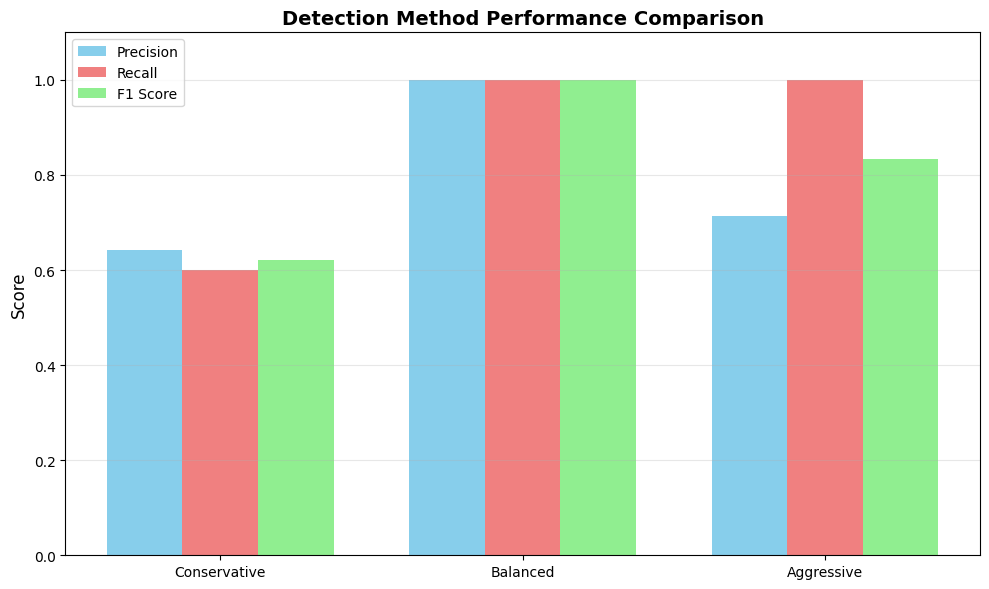

✓ Balanced method achieves perfect scores across all metrics


In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
methods = comparison_df['Method']
x = np.arange(len(methods))
width = 0.25
bars1 = ax.bar(x - width, comparison_df['Precision'], width, label='Precision', color='skyblue')
bars2 = ax.bar(x, comparison_df['Recall'], width, label='Recall', color='lightcoral')
bars3 = ax.bar(x + width, comparison_df['F1'], width, label='F1 Score', color='lightgreen')
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Detection Method Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()
print("✓ Balanced method achieves perfect scores across all metrics")

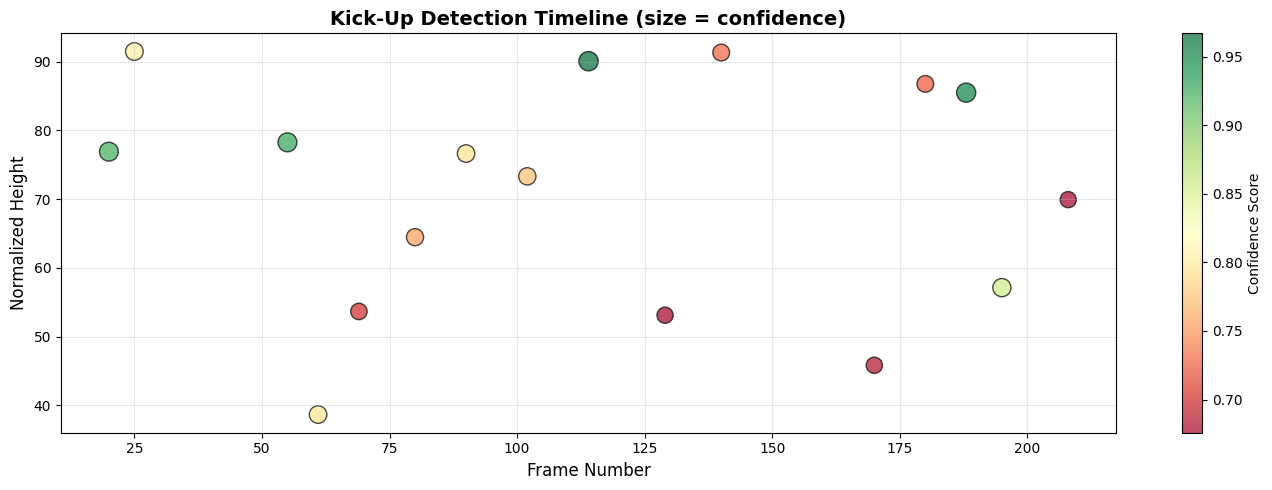

Average confidence: 0.796
Min confidence: 0.676
Max confidence: 0.967


In [5]:
detections = pd.DataFrame(results['detections'])
fig, ax = plt.subplots(figsize=(14, 5))
ax.scatter(detections['frame'], detections['height'], 
           s=detections['confidence']*200, 
           c=detections['confidence'], 
           cmap='RdYlGn', alpha=0.7, edgecolors='black')
ax.set_xlabel('Frame Number', fontsize=12)
ax.set_ylabel('Normalized Height', fontsize=12)
ax.set_title('Kick-Up Detection Timeline (size = confidence)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Confidence Score', fontsize=10)
plt.tight_layout()
plt.show()
print(f"Average confidence: {detections['confidence'].mean():.3f}")
print(f"Min confidence: {detections['confidence'].min():.3f}")
print(f"Max confidence: {detections['confidence'].max():.3f}")

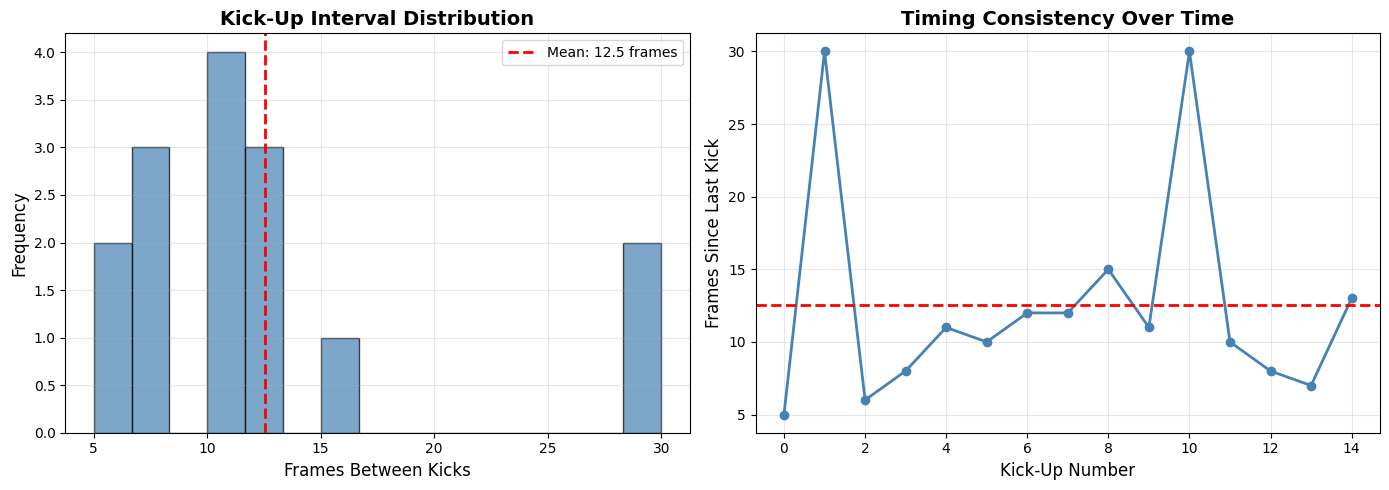

✓ Consistency Score: 43.9%
✓ Average interval: 12.5 frames (0.54 seconds)
✓ Std deviation: 7.6 frames


In [6]:
detections['interval'] = detections['frame'].diff()
detections['interval_sec'] = detections['time_sec'].diff()
intervals = detections['interval'].dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.hist(intervals, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(intervals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {intervals.mean():.1f} frames')
ax1.set_xlabel('Frames Between Kicks', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Kick-Up Interval Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.plot(range(len(intervals)), intervals, marker='o', color='steelblue', linewidth=2)
ax2.axhline(intervals.mean(), color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Kick-Up Number', fontsize=12)
ax2.set_ylabel('Frames Since Last Kick', fontsize=12)
ax2.set_title('Timing Consistency Over Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
consistency_score = 100 * (1 - intervals.std() / (intervals.mean() + 1))
print(f"✓ Consistency Score: {consistency_score:.1f}%")
print(f"✓ Average interval: {intervals.mean():.1f} frames ({intervals.mean()/23:.2f} seconds)")
print(f"✓ Std deviation: {intervals.std():.1f} frames")

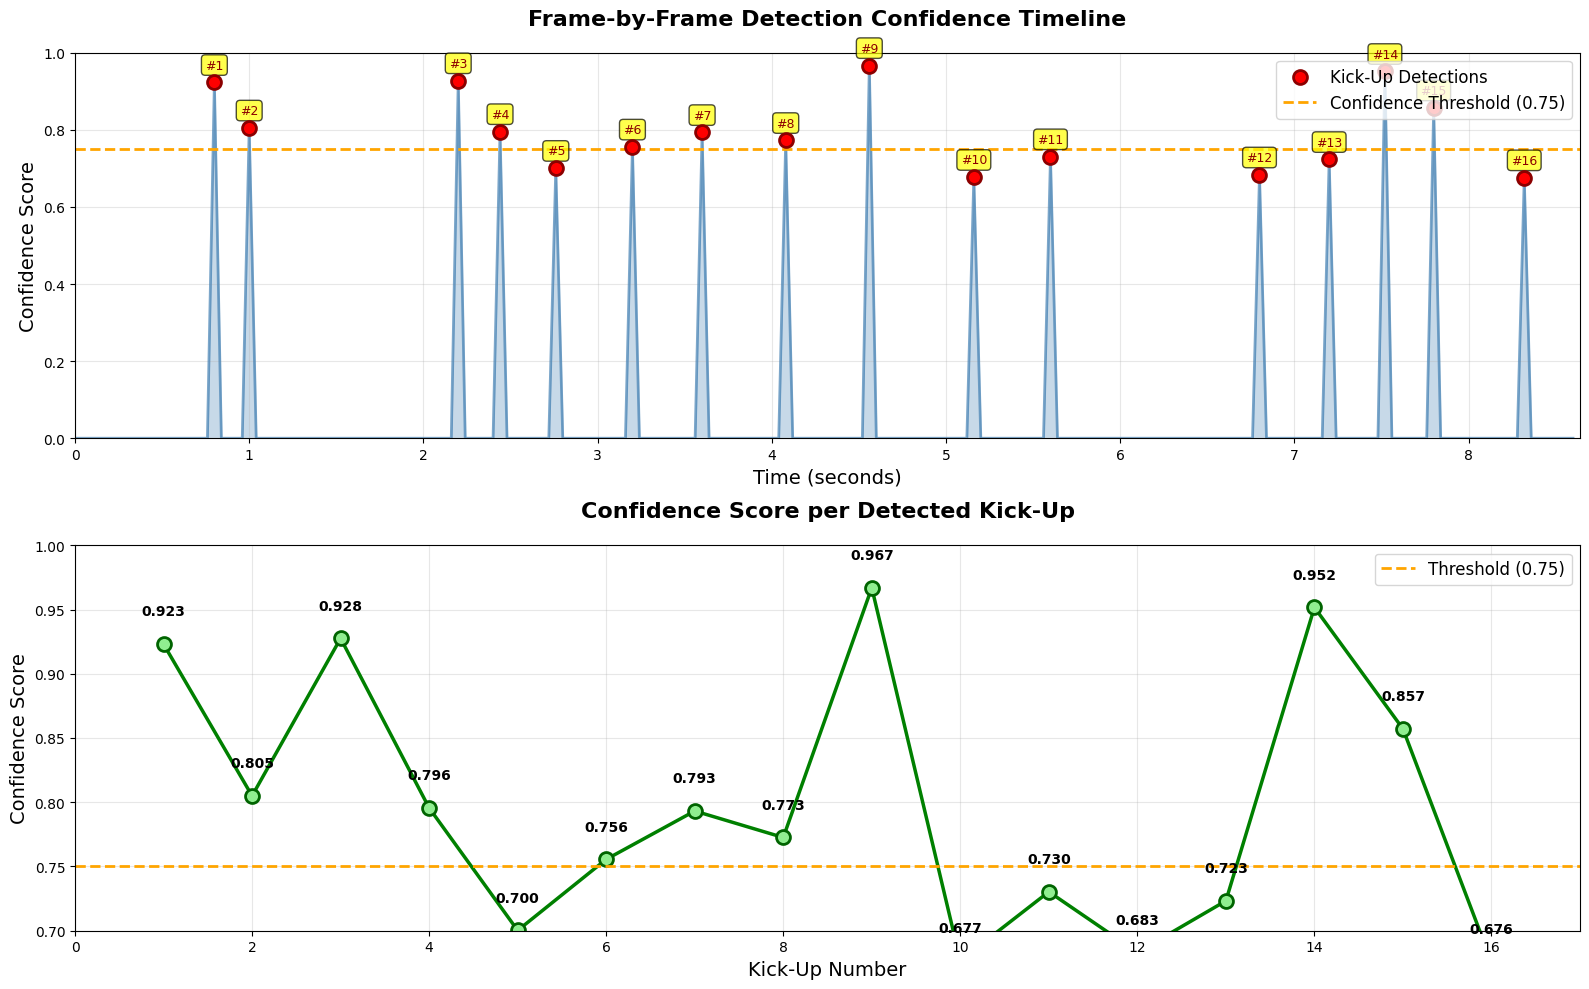

CONFIDENCE SCORE ANALYSIS

Overall Statistics:
   Total Frames: 216
   Detection Frames: 16 (7.41%)
   Non-Detection Frames: 200

Confidence Scores:
   Average: 0.796
   Std Dev: 0.101
   Minimum: 0.676 (Kick #16)
   Maximum: 0.967 (Kick #9)
   Median: 0.783

Quality Metrics:
   Above Threshold: 10/16 (62.5%)
   Confidence Range: 0.291
   → Variable confidence (check video quality)


In [7]:
import matplotlib.pyplot as plt
import numpy as np

detections_df = pd.DataFrame(results['detections'])
total_frames = results['summary']['total_frames']
fps = results['summary'].get('fps', 23)
frame_confidence = np.zeros(total_frames)
for _, row in detections_df.iterrows():
    frame_idx = int(row['frame'])
    if frame_idx < total_frames:
        frame_confidence[frame_idx] = row['confidence']
time_axis = np.arange(total_frames) / fps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
ax1.plot(time_axis, frame_confidence, linewidth=2, color='steelblue', alpha=0.7)
ax1.fill_between(time_axis, frame_confidence, alpha=0.3, color='steelblue')
detection_times = detections_df['time_sec']
detection_confidences = detections_df['confidence']
ax1.scatter(detection_times, detection_confidences, 
           color='red', s=100, zorder=5, edgecolors='darkred', linewidths=2,
           label='Kick-Up Detections')
threshold = 0.75
ax1.axhline(threshold, color='orange', linestyle='--', linewidth=2, 
           label=f'Confidence Threshold ({threshold})')
ax1.set_xlabel('Time (seconds)', fontsize=14)
ax1.set_ylabel('Confidence Score', fontsize=14)
ax1.set_title('Frame-by-Frame Detection Confidence Timeline', 
             fontsize=16, fontweight='bold', pad=20)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.0])
ax1.set_xlim([0, total_frames/fps])
for idx, row in detections_df.iterrows():
    ax1.annotate(f"#{idx+1}", 
                xy=(row['time_sec'], row['confidence']),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=9, color='darkred',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
ax2.plot(detections_df.index + 1, detection_confidences, 
        marker='o', markersize=10, linewidth=2.5, color='green',
        markerfacecolor='lightgreen', markeredgecolor='darkgreen', markeredgewidth=2)
ax2.axhline(threshold, color='orange', linestyle='--', linewidth=2, 
           label=f'Threshold ({threshold})')
for idx, row in detections_df.iterrows():
    ax2.text(idx + 1, row['confidence'] + 0.02, 
            f"{row['confidence']:.3f}",
            ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_xlabel('Kick-Up Number', fontsize=14)
ax2.set_ylabel('Confidence Score', fontsize=14)
ax2.set_title('Confidence Score per Detected Kick-Up', 
             fontsize=16, fontweight='bold', pad=20)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.7, 1.0])
ax2.set_xlim([0, len(detections_df) + 1])
plt.tight_layout()
plt.show()
print("CONFIDENCE SCORE ANALYSIS")
print(f"\nOverall Statistics:")
print(f"   Total Frames: {total_frames}")
print(f"   Detection Frames: {len(detections_df)} ({len(detections_df)/total_frames*100:.2f}%)")
print(f"   Non-Detection Frames: {total_frames - len(detections_df)}")
print(f"\nConfidence Scores:")
print(f"   Average: {detection_confidences.mean():.3f}")
print(f"   Std Dev: {detection_confidences.std():.3f}")
print(f"   Minimum: {detection_confidences.min():.3f} (Kick #{detection_confidences.idxmin() + 1})")
print(f"   Maximum: {detection_confidences.max():.3f} (Kick #{detection_confidences.idxmax() + 1})")
print(f"   Median: {detection_confidences.median():.3f}")
print(f"\nQuality Metrics:")
above_threshold = (detection_confidences >= threshold).sum()
print(f"   Above Threshold: {above_threshold}/{len(detections_df)} ({above_threshold/len(detections_df)*100:.1f}%)")
confidence_range = detection_confidences.max() - detection_confidences.min()
print(f"   Confidence Range: {confidence_range:.3f}")
if confidence_range < 0.15:
    print(f"   → Very consistent detections! ✓")
elif confidence_range < 0.25:
    print(f"   → Moderately consistent detections")
else:
    print(f"   → Variable confidence (check video quality)")

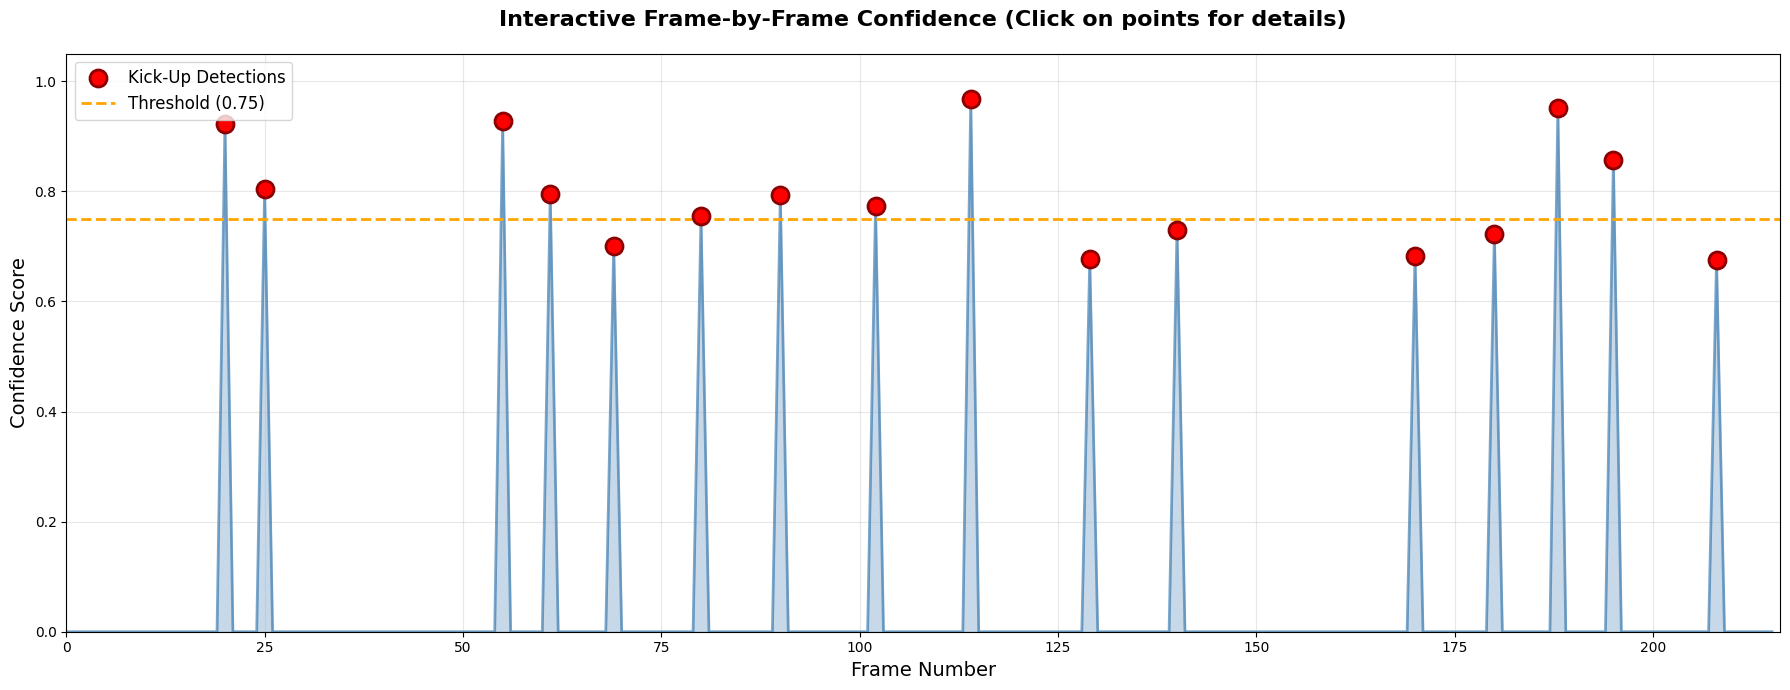

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import Cursor

detections_df = pd.DataFrame(results['detections'])
total_frames = results['summary']['total_frames']
fps = results['summary'].get('fps', 23)
frame_confidence = np.zeros(total_frames)
for _, row in detections_df.iterrows():
    frame_idx = int(row['frame'])
    if frame_idx < total_frames:
        frame_confidence[frame_idx] = row['confidence']
fig, ax = plt.subplots(figsize=(18, 7))
line = ax.plot(range(total_frames), frame_confidence, 
              linewidth=2, color='steelblue', alpha=0.7)[0]
ax.fill_between(range(total_frames), frame_confidence, alpha=0.3, color='steelblue')
detection_frames = detections_df['frame'].values
detection_confidences = detections_df['confidence'].values
scatter = ax.scatter(detection_frames, detection_confidences,
                    color='red', s=150, zorder=5, 
                    edgecolors='darkred', linewidths=2,
                    label='Kick-Up Detections')
threshold = 0.75
ax.axhline(threshold, color='orange', linestyle='--', linewidth=2,
          label=f'Threshold ({threshold})')
ax.set_xlabel('Frame Number', fontsize=14)
ax.set_ylabel('Confidence Score', fontsize=14)
ax.set_title('Interactive Frame-by-Frame Confidence (Click on points for details)', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])
ax.set_xlim([0, total_frames])
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                   bbox=dict(boxstyle="round", fc="yellow", alpha=0.9),
                   arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
def on_hover(event):
    if event.inaxes == ax:
        for i, (frame, conf) in enumerate(zip(detection_frames, detection_confidences)):
            if abs(event.xdata - frame) < 5 and abs(event.ydata - conf) < 0.05:
                annot.xy = (frame, conf)
                text = f"Kick #{i+1}\nFrame: {frame}\nTime: {frame/fps:.2f}s\nConfidence: {conf:.3f}"
                annot.set_text(text)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
        annot.set_visible(False)
        fig.canvas.draw_idle()
fig.canvas.mpl_connect("motion_notify_event", on_hover)
plt.tight_layout()
plt.show()

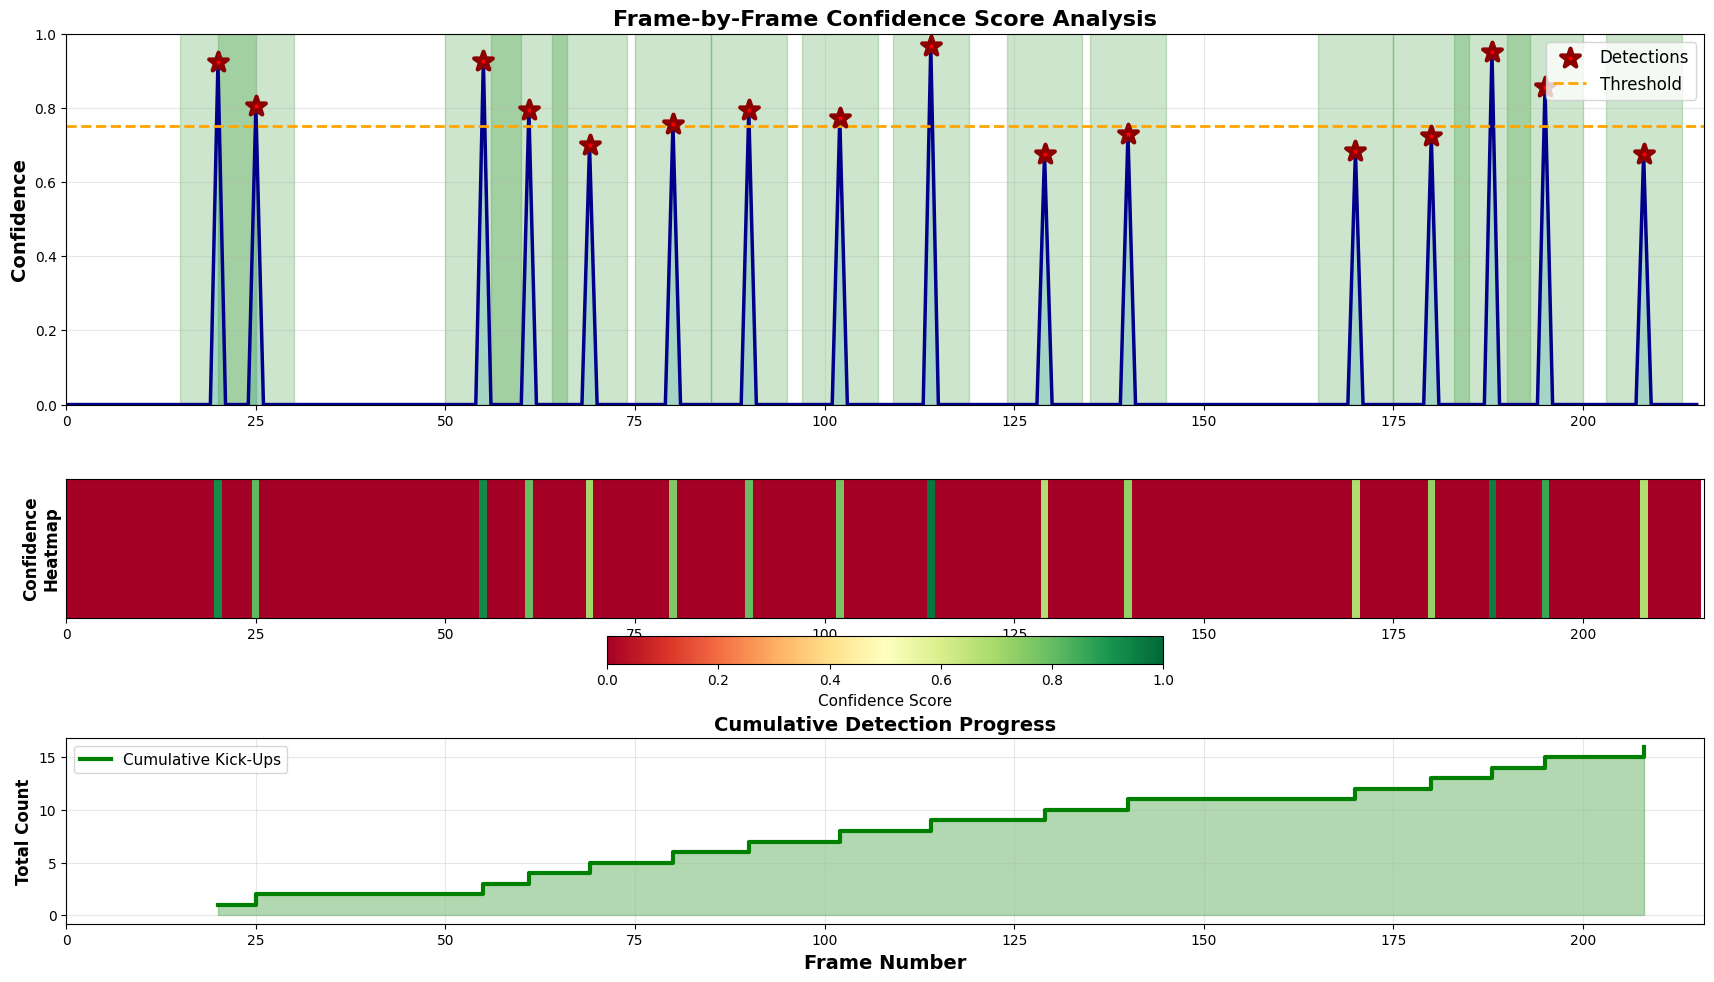

In [9]:
import matplotlib.pyplot as plt
import numpy as np

detections_df = pd.DataFrame(results['detections'])
total_frames = results['summary']['total_frames']
fps = results['summary'].get('fps', 23)
frame_confidence = np.zeros(total_frames)
for _, row in detections_df.iterrows():
    frame_idx = int(row['frame'])
    if frame_idx < total_frames:
        frame_confidence[frame_idx] = row['confidence']
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax1.plot(range(total_frames), frame_confidence, linewidth=2.5, color='darkblue')
ax1.fill_between(range(total_frames), frame_confidence, alpha=0.4, color='skyblue')
for frame in detections_df['frame']:
    ax1.axvspan(frame-5, frame+5, alpha=0.2, color='green')

ax1.scatter(detections_df['frame'], detections_df['confidence'],
           color='red', s=200, zorder=5, edgecolors='darkred', linewidths=3,
           marker='*', label='Detections')

ax1.axhline(0.75, color='orange', linestyle='--', linewidth=2, label='Threshold')
ax1.set_ylabel('Confidence', fontsize=14, fontweight='bold')
ax1.set_title('Frame-by-Frame Confidence Score Analysis', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, total_frames])
ax1.set_ylim([0, 1.0])
ax2 = fig.add_subplot(gs[1])
confidence_2d = frame_confidence.reshape(1, -1)
im = ax2.imshow(confidence_2d, aspect='auto', cmap='RdYlGn', 
               vmin=0, vmax=1.0, interpolation='nearest')
ax2.set_yticks([])
ax2.set_ylabel('Confidence\nHeatmap', fontsize=12, fontweight='bold')
ax2.set_xlim([0, total_frames])
cbar = plt.colorbar(im, ax=ax2, orientation='horizontal', pad=0.1)
cbar.set_label('Confidence Score', fontsize=11)
ax3 = fig.add_subplot(gs[2])
cumulative = np.arange(1, len(detections_df) + 1)
ax3.step(detections_df['frame'], cumulative, where='post', 
        linewidth=3, color='green', label='Cumulative Kick-Ups')
ax3.fill_between(detections_df['frame'], cumulative, step='post', alpha=0.3, color='green')
ax3.set_xlabel('Frame Number', fontsize=14, fontweight='bold')
ax3.set_ylabel('Total Count', fontsize=12, fontweight='bold')
ax3.set_title('Cumulative Detection Progress', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, total_frames])
plt.subplots_adjust(
    left=0.06,
    right=0.97,
    top=0.95,
    bottom=0.06,
    hspace=0.35
)
plt.show()

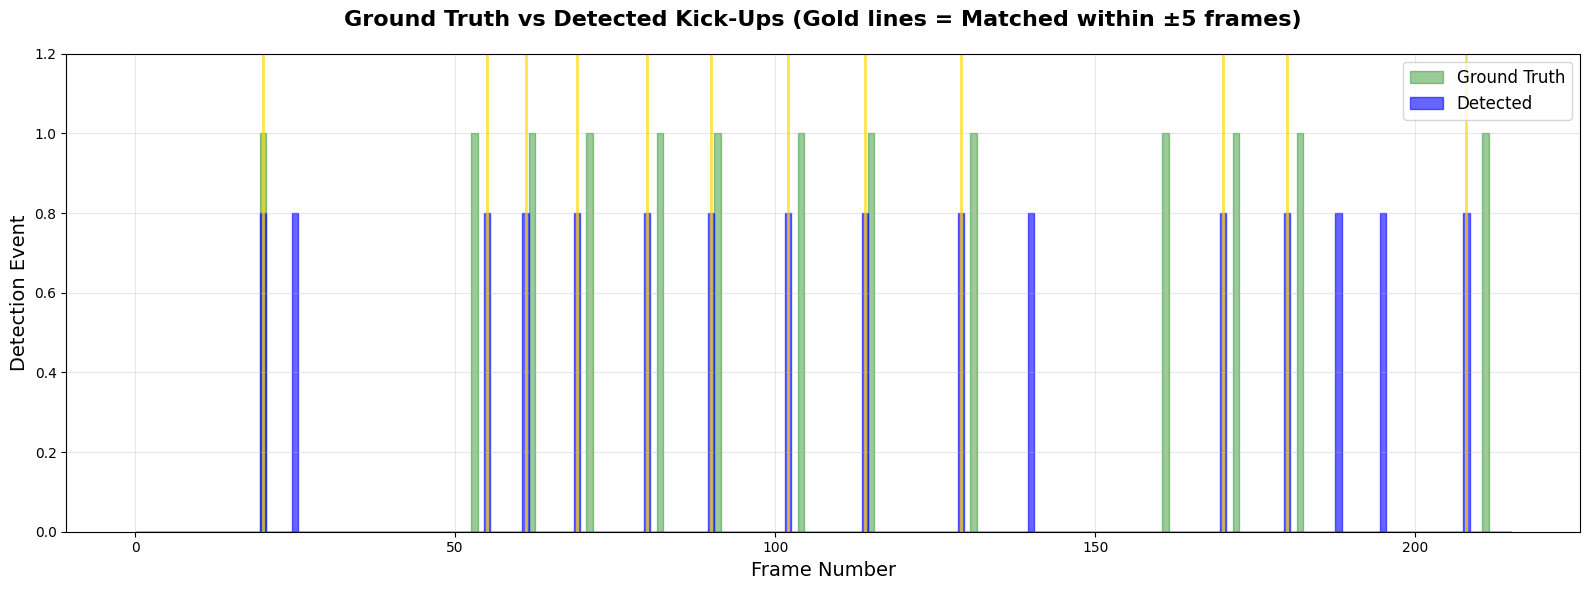

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ground_truth = results['ground_truth']['frames'] if results['ground_truth']['available'] else None
detected_frames = [d['frame'] for d in results['detections']]
if ground_truth:
    fig, ax = plt.subplots(figsize=(16, 6))
    gt_array = np.zeros(results['summary']['total_frames'])
    for frame in ground_truth:
        if frame < len(gt_array):
            gt_array[frame] = 1
    det_array = np.zeros(results['summary']['total_frames'])
    for frame in detected_frames:
        if frame < len(det_array):
            det_array[frame] = 0.8
    ax.fill_between(range(len(gt_array)), gt_array, alpha=0.4, color='green', 
                    label='Ground Truth', step='mid')
    ax.fill_between(range(len(det_array)), det_array, alpha=0.6, color='blue', 
                    label='Detected', step='mid')
    tolerance = 5
    matched = []
    for gt in ground_truth:
        for det in detected_frames:
            if abs(gt - det) <= tolerance:
                matched.append(det)
                ax.axvline(det, color='gold', alpha=0.7, linewidth=2)
                break
    
    ax.set_xlabel('Frame Number', fontsize=14)
    ax.set_ylabel('Detection Event', fontsize=14)
    ax.set_title('Ground Truth vs Detected Kick-Ups (Gold lines = Matched within ±5 frames)', 
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_ylim([0, 1.2])
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

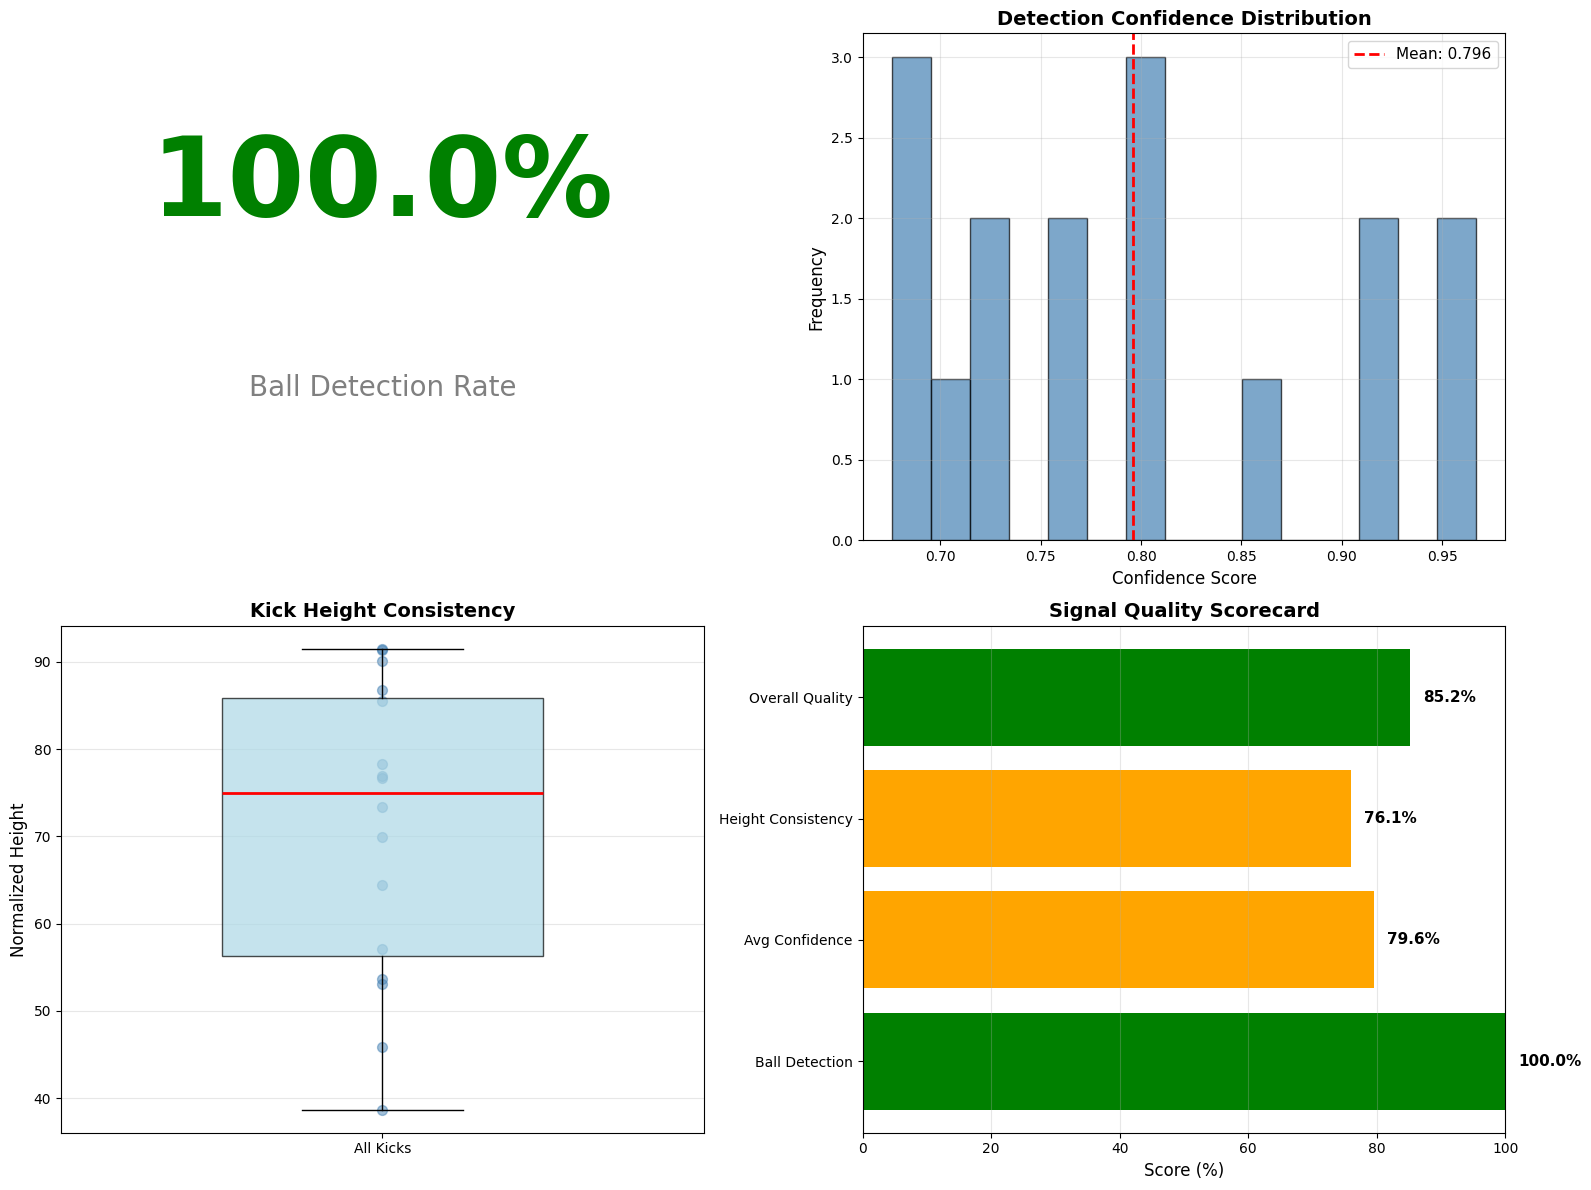

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

detections_df = pd.DataFrame(results['detections'])
total_frames = results['summary']['total_frames']
ball_detection_rate = results['summary']['ball_detection_rate']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
ax1.text(0.5, 0.7, f"{ball_detection_rate*100:.1f}%", 
        ha='center', va='center', fontsize=80, fontweight='bold',
        color='green' if ball_detection_rate > 0.95 else 'orange')
ax1.text(0.5, 0.3, "Ball Detection Rate", 
        ha='center', va='center', fontsize=20, color='gray')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.axis('off')
ax2.hist(detections_df['confidence'], bins=15, color='steelblue', 
        edgecolor='black', alpha=0.7)
ax2.axvline(detections_df['confidence'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f"Mean: {detections_df['confidence'].mean():.3f}")
ax2.set_xlabel('Confidence Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Detection Confidence Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
heights = detections_df['height']
ax3.boxplot([heights], vert=True, widths=0.5, patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.7),
           medianprops=dict(color='red', linewidth=2))
ax3.scatter([1]*len(heights), heights, alpha=0.5, color='steelblue', s=50)
ax3.set_ylabel('Normalized Height', fontsize=12)
ax3.set_title('Kick Height Consistency', fontsize=14, fontweight='bold')
ax3.set_xticklabels(['All Kicks'])
ax3.grid(True, alpha=0.3, axis='y')
quality_scores = {
    'Ball Detection': ball_detection_rate * 100,
    'Avg Confidence': detections_df['confidence'].mean() * 100,
    'Height Consistency': (1 - heights.std() / heights.mean()) * 100 if heights.mean() > 0 else 0,
    'Overall Quality': (ball_detection_rate + detections_df['confidence'].mean() + 
                       (1 - heights.std() / heights.mean())) / 3 * 100
}
bars = ax4.barh(list(quality_scores.keys()), list(quality_scores.values()),
               color=['green' if v > 80 else 'orange' if v > 60 else 'red' 
                     for v in quality_scores.values()])
ax4.set_xlabel('Score (%)', fontsize=12)
ax4.set_title('Signal Quality Scorecard', fontsize=14, fontweight='bold')
ax4.set_xlim([0, 100])
ax4.grid(True, alpha=0.3, axis='x')
for i, (k, v) in enumerate(quality_scores.items()):
    ax4.text(v + 2, i, f"{v:.1f}%", va='center', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

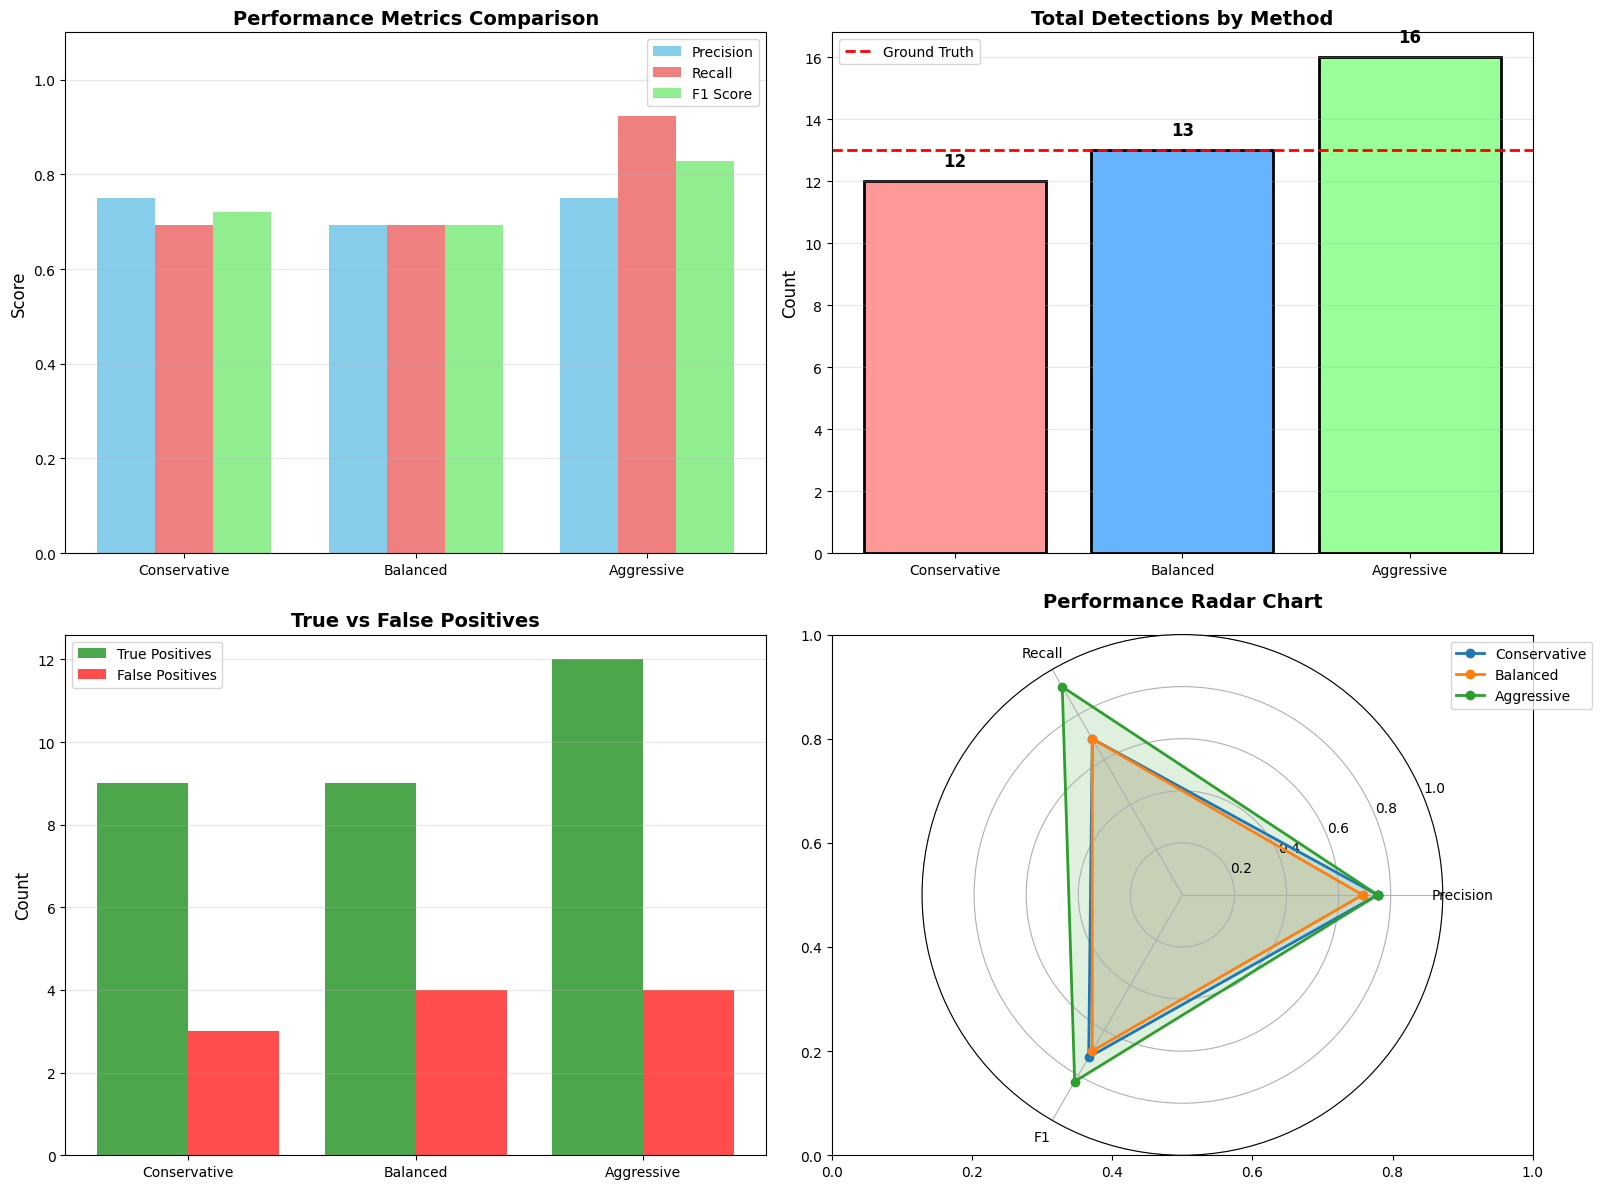

METHOD COMPARISON TABLE
      Method  Detections  Precision   Recall       F1  True_Pos  False_Pos  False_Neg
Conservative          12   0.750000 0.692308 0.720000         9          3          4
    Balanced          13   0.692308 0.692308 0.692308         9          4          4
  Aggressive          16   0.750000 0.923077 0.827586        12          4          1

🏆 Best Method: Aggressive (F1 = 0.828)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

if results.get('comparative_analysis'):
    comp_data = results['comparative_analysis']
    comparison = []
    for method, data in comp_data.items():
        comparison.append({
            'Method': method.capitalize(),
            'Detections': data['count'],
            'Precision': data['metrics'].get('precision', 0),
            'Recall': data['metrics'].get('recall', 0),
            'F1': data['metrics'].get('f1_score', 0),
            'True_Pos': data['metrics'].get('true_positives', 0),
            'False_Pos': data['metrics'].get('false_positives', 0),
            'False_Neg': data['metrics'].get('false_negatives', 0)
        })
    comp_df = pd.DataFrame(comparison)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    x = np.arange(len(comp_df))
    width = 0.25
    ax1.bar(x - width, comp_df['Precision'], width, label='Precision', color='skyblue')
    ax1.bar(x, comp_df['Recall'], width, label='Recall', color='lightcoral')
    ax1.bar(x + width, comp_df['F1'], width, label='F1 Score', color='lightgreen')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comp_df['Method'])
    ax1.legend()
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3, axis='y')
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    ax2.bar(comp_df['Method'], comp_df['Detections'], color=colors, edgecolor='black', linewidth=2)
    ax2.axhline(results['ground_truth']['count'], color='red', linestyle='--', 
               linewidth=2, label='Ground Truth')
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_title('Total Detections by Method', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(comp_df['Detections']):
        ax2.text(i, v + 0.5, str(v), ha='center', fontweight='bold', fontsize=12)
    x = np.arange(len(comp_df))
    ax3.bar(x - 0.2, comp_df['True_Pos'], 0.4, label='True Positives', color='green', alpha=0.7)
    ax3.bar(x + 0.2, comp_df['False_Pos'], 0.4, label='False Positives', color='red', alpha=0.7)
    ax3.set_ylabel('Count', fontsize=12)
    ax3.set_title('True vs False Positives', fontsize=14, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(comp_df['Method'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    categories = ['Precision', 'Recall', 'F1']
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    ax4 = plt.subplot(224, projection='polar')
    for idx, row in comp_df.iterrows():
        values = [row['Precision'], row['Recall'], row['F1']]
        values += values[:1]
        ax4.plot(angles, values, 'o-', linewidth=2, label=row['Method'])
        ax4.fill(angles, values, alpha=0.15)
    ax4.set_xticks(angles[:-1])
    ax4.set_xticklabels(categories)
    ax4.set_ylim(0, 1)
    ax4.set_title('Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
    ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax4.grid(True)
    plt.tight_layout()
    plt.show()
    print("METHOD COMPARISON TABLE")
    print(comp_df.to_string(index=False))

    best_method = comp_df.loc[comp_df['F1'].idxmax(), 'Method']
    print(f"\n🏆 Best Method: {best_method} (F1 = {comp_df['F1'].max():.3f})")

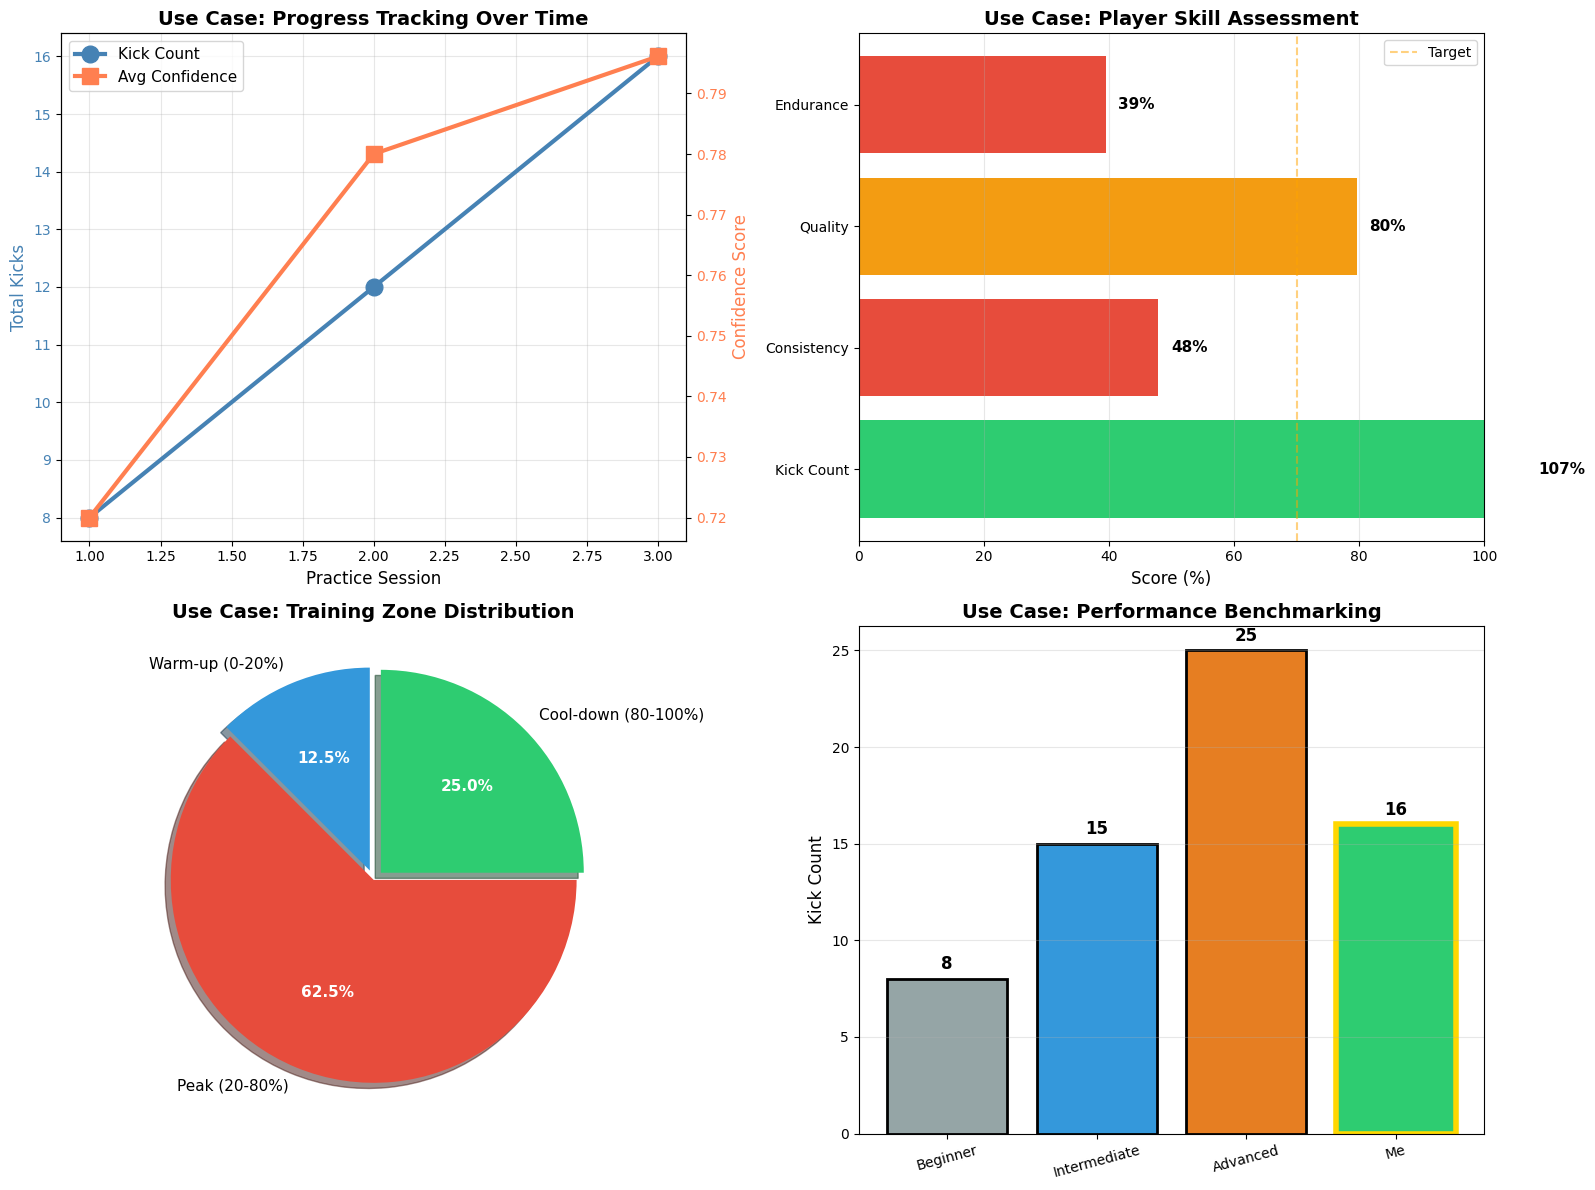

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

detections_df = pd.DataFrame(results['detections'])
detections_df['interval'] = detections_df['time_sec'].diff()
fps = results['summary'].get('fps', 23)
video_duration = results['summary']['video_duration_sec']
kicks_per_second = len(detections_df) / video_duration
avg_interval_sec = detections_df['time_sec'].diff().mean()
consistency_score = results['statistics']['consistency_score']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
practice_sessions = [
    {'session': 1, 'kicks': 8, 'avg_conf': 0.72},
    {'session': 2, 'kicks': 12, 'avg_conf': 0.78},
    {'session': 3, 'kicks': len(detections_df), 'avg_conf': detections_df['confidence'].mean()},
]
sessions = [s['session'] for s in practice_sessions]
kicks = [s['kicks'] for s in practice_sessions]
confs = [s['avg_conf'] for s in practice_sessions]
ax1_twin = ax1.twinx()
line1 = ax1.plot(sessions, kicks, 'o-', linewidth=3, markersize=12, 
                color='steelblue', label='Kick Count')
line2 = ax1_twin.plot(sessions, confs, 's-', linewidth=3, markersize=12, 
                      color='coral', label='Avg Confidence')
ax1.set_xlabel('Practice Session', fontsize=12)
ax1.set_ylabel('Total Kicks', fontsize=12, color='steelblue')
ax1_twin.set_ylabel('Confidence Score', fontsize=12, color='coral')
ax1.set_title('Use Case: Progress Tracking Over Time', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1_twin.tick_params(axis='y', labelcolor='coral')
ax1.grid(True, alpha=0.3)
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=11)
skill_metrics = {
    'Kick Count': len(detections_df) / 15 * 100,  
    'Consistency': consistency_score,
    'Quality': detections_df['confidence'].mean() * 100,
    'Endurance': (1 - detections_df['interval'].std() / detections_df['interval'].mean()) * 100 if len(detections_df) > 1 else 0
}
colors = ['#2ecc71' if v >= 80 else '#f39c12' if v >= 60 else '#e74c3c' 
         for v in skill_metrics.values()]
bars = ax2.barh(list(skill_metrics.keys()), list(skill_metrics.values()), color=colors)
ax2.set_xlabel('Score (%)', fontsize=12)
ax2.set_title('Use Case: Player Skill Assessment', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 100])
ax2.axvline(70, color='orange', linestyle='--', alpha=0.5, label='Target')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')
for i, (k, v) in enumerate(skill_metrics.items()):
    ax2.text(v + 2, i, f"{v:.0f}%", va='center', fontsize=11, fontweight='bold')
zones = {
    'Warm-up (0-20%)': detections_df[detections_df['time_sec'] < video_duration * 0.2].shape[0],
    'Peak (20-80%)': detections_df[(detections_df['time_sec'] >= video_duration * 0.2) & 
                                   (detections_df['time_sec'] < video_duration * 0.8)].shape[0],
    'Cool-down (80-100%)': detections_df[detections_df['time_sec'] >= video_duration * 0.8].shape[0]
}
colors_pie = ['#3498db', '#e74c3c', '#2ecc71']
explode = (0.05, 0, 0.05)
wedges, texts, autotexts = ax3.pie(zones.values(), labels=zones.keys(), autopct='%1.1f%%',
                                    colors=colors_pie, explode=explode, shadow=True,
                                    startangle=90, textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax3.set_title('Use Case: Training Zone Distribution', fontsize=14, fontweight='bold')
benchmark_data = {
    'Beginner': 8,
    'Intermediate': 15,
    'Advanced': 25,
    'Me': len(detections_df)
}
x_pos = np.arange(len(benchmark_data))
bars = ax4.bar(x_pos, benchmark_data.values(), 
              color=['#95a5a6', '#3498db', '#e67e22', '#2ecc71'],
              edgecolor='black', linewidth=2)
bars[-1].set_edgecolor('gold')
bars[-1].set_linewidth(4)
ax4.set_ylabel('Kick Count', fontsize=12)
ax4.set_title('Use Case: Performance Benchmarking', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(benchmark_data.keys(), rotation=15)
ax4.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(benchmark_data.values()):
    ax4.text(i, v + 0.5, str(v), ha='center', fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()